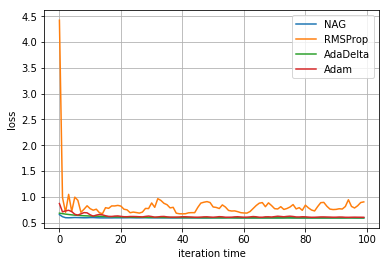

In [1]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import random
import math as mt
import matplotlib.pyplot as plt

# 读取数据
x_train, y_train = load_svmlight_file("a9a.txt", n_features=123)
x_test, y_test = load_svmlight_file("a9a_test.txt", n_features=123)

x_train = x_train.toarray()
x_test = x_test.toarray()
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

index_range = range(0, x_train.shape[0])


# 随机选取部分样本
def stochastic_samples(x, y, n):
    samples_index = random.sample(index_range, n)
    x_samples = np.zeros((0, x.shape[1]))
    y_samples = np.zeros((0, y.shape[1]))

    for i in samples_index:
        x_samples = np.r_[x_samples, x[i].reshape(1, x.shape[1])]
        y_samples = np.r_[y_samples, y[i].reshape(1, y.shape[1])]

    return x_samples, y_samples


# NAG
def NAG(x, y, w, params):
    w_new = w - params['GAMMA'] * params['Vt']
    gradient_temp = np.zeros(w.shape)
    for index in range(0, y.shape[0]):
        xi = x[index].reshape(x.shape[1], 1)
        yi = y[index][0]

        gradient_temp += yi / (1 + mt.exp(yi * np.dot(w_new.T, xi)[0][0])) * xi

    gradient = LAMBDA * w_new - 1 / batch_num * gradient_temp

    params['Vt'] = params['GAMMA'] * params['Vt'] + params['learning_rate'] * gradient
    w = w - params['Vt']

    return w, params


# RMSProp
def RMSProp(x, y, w, params):
    EPSILON = 1e-8

    loss_gradient = np.zeros(w.shape)
    for index in range(0, y.shape[0]):
        xi = x[index].reshape(1, x.shape[1]).T
        yi = y[index][0]

        loss_gradient += yi / (1 + mt.exp(yi * np.dot(w.T, xi)[0][0])) * xi

    gradient = LAMBDA * w - 1 / batch_num * loss_gradient

    params['Gt'] = params['GAMMA'] * params['Gt'] + (1 - params['GAMMA']) * (gradient * gradient)
    w = w - (params['learning_rate'] / np.sqrt(params['Gt'] + EPSILON)) * gradient

    return w, params


# AdaDelta
def AdaDelta(x, y, w, params):
    EPSILON = 1e-8
    GAMMA = params['GAMMA']

    loss_gradient = np.zeros(w.shape)
    for index in range(0, y.shape[0]):
        xi = x[index].reshape(1, x.shape[1]).T
        yi = y[index][0]

        loss_gradient += yi / (1 + mt.exp(yi * np.dot(w.T, xi)[0][0])) * xi

    gradient = LAMBDA * w - 1 / batch_num * loss_gradient

    params['Gt'] = GAMMA * params['Gt'] + (1 - GAMMA) * (gradient * gradient)
    Delta_W = -(np.sqrt(params['Delta_t'] + EPSILON) / np.sqrt(params['Gt'] + EPSILON)) * gradient
    params['Delta_t'] = GAMMA * params['Delta_t'] + (1 - GAMMA) * (Delta_W * Delta_W)
    w = w + Delta_W

    return w, params


# Adam
def Adam(x, y, w, params):
    BETA1 = 0.9
    GAMMA = params['GAMMA']
    EPSILON = 1e-8
    gradient_temp = np.zeros(w.shape)
    for index in range(0, y.shape[0]):
        xi = x[index].reshape(x.shape[1], 1)
        yi = y[index][0]

        gradient_temp += yi / (1 + mt.exp(yi * np.dot(w.T, xi)[0][0])) * xi

    gradient = LAMBDA * w - 1 / batch_num * gradient_temp

    params['mt'] = BETA1 * params['mt'] + (1 - BETA1) * gradient
    params['Gt'] = GAMMA * params['Gt'] + (1 - GAMMA) * (gradient * gradient)
    ALPHA = params['learning_rate'] * mt.sqrt(1 - GAMMA ** params['iteration']) / (1 - BETA1 ** params['iteration'])
    w = w - ALPHA * (params['mt'] / np.sqrt(params['Gt'] + EPSILON))

    return w, params


# 参数的初始化
LAMBDA = 1
batch_num = 100
threshold = 0.5
iter_num = 100

NAG_loss_list = []
RMSProp_loss_list = []
AdaDelta_loss_list = []
Adam_loss_list = []
loss_list = {'NAG': NAG_loss_list,
             'RMSProp': RMSProp_loss_list,
             'AdaDelta': AdaDelta_loss_list,
             'Adam': Adam_loss_list
             }

algorithm_list = [NAG, RMSProp, AdaDelta, Adam]
algorithm_names = ['NAG', 'RMSProp', 'AdaDelta', 'Adam']

# 逻辑回归
for algorithm_index in range(int(len(algorithm_list))):
    w = np.zeros((x_train.shape[1], 1))
    algorithm_params = {'Vt': np.zeros(w.shape),
                        'Gt': np.zeros(w.shape),
                        'Delta_t': np.zeros(w.shape),
                        'mt': np.zeros(w.shape),
                        'learning_rate': 0.1,
                        'GAMMA': 0.9,
                        'BETA1': 0.9,
                        'iteration': 1,
                        }

    if algorithm_list[algorithm_index] == AdaDelta:
        algorithm_params['GAMMA'] = 0.999

    for i in range(0, iter_num):
        x_samples, y_samples = stochastic_samples(x_train, y_train, batch_num)
        w, algorithm_params = algorithm_list[algorithm_index](x_samples, y_samples, w, algorithm_params)
        algorithm_params['iteration'] = i + 1

        loss_sum = 0
        for index in range(0, y_test.shape[0]):
            xi = x_test[index].reshape(1, x_test.shape[1]).T
            yi = y_test[index][0]

            wtxi = np.dot(w.T, xi)[0][0]
            loss_sum += mt.log(1 + mt.exp(-yi * wtxi))

        test_loss = LAMBDA * 1 / 2 * np.dot(w.T, w)[0][0] + 1 / x_test.shape[0] * loss_sum
        loss_list[algorithm_names[algorithm_index]].append(test_loss)

# 绘制四种优化算法的损失率曲线
plt.xlabel('iteration time')
plt.ylabel('loss')

x = range(iter_num)
plt.plot(x, NAG_loss_list, label='NAG')
plt.plot(x, RMSProp_loss_list, label='RMSProp')
plt.plot(x, AdaDelta_loss_list, label='AdaDelta')
plt.plot(x, Adam_loss_list, label='Adam')
plt.title(u'logistic regression')
plt.xlabel(u"epoch")
plt.ylabel(u"error")

plt.grid(True)
plt.legend()
plt.show()

